In [4]:
from simtk import unit
from openmm import app

from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
from utils import *

import os

class BaseSimulator():
    """
    .. warning :: The base class should not be used directly

    Parameters
    ------------
    temperature : simtk.unit
        default 298.15 K
    pressure : simtk.unit
        default 1.013 bar
    time_step : simtk.unit
        default 2 fs


    .. todo::
        - setter and getter for phy constants
    """

    temperature = 298.15 * unit.kelvin
    pressure = 1.013 * unit.bar
    time_step = 0.002 * unit.picoseconds
    equil_steps = 50000  #100 ps

    @classmethod
    def via_openmm(cls, parmed_obj, file_name, file_path = "./", platform = "CUDA", num_steps = 5000 * 500, write_out_freq = 5000, report_equilibration = True, report_production = False,
    constrain_all_bonds = True, **kwargs):
        """
        Runs simulation using OpenMM.

        Parameters
        ------------
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.
        file_name : str
            No file type postfix is necessary
        file_path : str
            Default to current directory
        platform : str
            The computing architecture to do the calculation, default to CUDA, CPU, OpenCL is also possible.
        num_steps : int
            Number of production simulation to run, default 2,500,000 steps, i.e. 5 ns.
        write_out_freq : int
            Write out every nth frame of simulated trajectory, default to every 5000 frame write out one, i.e. 10 ps per frame.

        Returns
        --------
        path : str
            The absolute path where the trajectory is written to.
        """
        platform = Platform.getPlatformByName(platform)
        pmd = parmed_obj
        path = '{}/{}.h5'.format(file_path, file_name)

        constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)


        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)
        barostat = MonteCarloBarostat(cls.pressure , cls.temperature)
        system.addForce(barostat)
        integrator = VerletIntegrator(cls.time_step)

        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        simulation.minimizeEnergy()
        print("Minimisation done")
        # Eq
        try:
            cls.equil_steps = kwargs["equil_steps"]
        except KeyError:
            cls.equil_steps = 50000  # Default value

        iteration_count = 0
        while True:
            simulation.reporters.append(StateDataReporter("{}/equilibration_{}.dat".format(file_path, file_name), cls.equil_steps//5000, step=True, volume=True, temperature=True, density=True))
            simulation.step(cls.equil_steps)

            # Read the equilibration file
            equilibration_file = "{}/equilibration_{}.dat".format(file_path, file_name)
            df_equilib = pd.read_csv(equilibration_file, delimiter=",")
            densities = df_equilib['Density (g/mL)']

            density_fluctuation = densities.max() - densities.min()
            print(f'Density fluctuation is {round(density_fluctuation,2)}')

            if density_fluctuation <= 0.1:
                print("Density fluctuation is below 0.1, proceeding to production")
                break
            elif iteration_count >= 5:
                raise ValueError("Density fluctuation is still high after 5 iterations, exiting") 
            else:
                print("which is higher than cut-off 0.1, re-equilibrating")
                os.remove(equilibration_file)
                iteration_count += 1
        
        state = simulation.context.getState(getPositions = True, getVelocities = True)
        pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(),state.getVelocities(), state.getPeriodicBoxVectors()

        #Production
        del system
        del simulation

        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)

        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)

        integrator = VerletIntegrator(cls.time_step)
        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        if report_production:
            simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy = True, temperature = True))
        simulation.reporters.append(HDF5Reporter(path, write_out_freq))
        simulation.step(num_steps)

        return os.path.abspath(path)
    



class SolutionSimulator(BaseSimulator):
    """
    Perform solution simulation, namely one copy of solute in water box. Currently identical to BaseSimulator

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 50,000 steps, i.e. 100 ps
    """
    equil_steps = 50000  #100 ps

class LiquidSimulator(BaseSimulator):
    """
    Perform liquid simulation, namely multiple copy of the same molecule.

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 500,000 steps, i.e. 1 ns
    """
    equil_steps = 500000  #1 ns


In [5]:
# Load the PDB file and XML system into ParmEd
import openmm
from openmm.app.pdbfile import PDBFile
import parmed
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/4f0c0007e8d044f9b3e95f744a4a674e_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/4f0c0007e8d044f9b3e95f744a4a674e_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)


In [6]:
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_benzene', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 0.24
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.02
Density fluctuation is below 0.1, proceeding to production


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_benzene.h5'

In [40]:
#example with low experimental density (pentane, 0.61 g/mL)
schema_id = '899401215785451f8733675e24b98a18'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_pentane_full_equil', file_path = './',
                             platform = "CUDA", num_steps = 5 * 5)

Minimisation done
Density fluctuation is 0.08
Density fluctuation is below 0.1, proceeding to production


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_pentane_full_equil.h5'

In [8]:
#example with high experimental density (pentane, 0.61 g/mL)
schema_id = 'e1baf18c2527499f8ce274620e805a09'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_1122tetrabromoethane', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 2.34
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.06
Density fluctuation is below 0.1, proceeding to production


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_1122tetrabromoethane.h5'

In [ ]:
#example with huge molecule
schema_id = 'e1baf18c2527499f8ce274620e805a09'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_long_boy', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

In [41]:
#example with chloroform
schema_id = '4a6a781c2b774a15ad79d7fc00fb2ebf'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_chloroform_full_equil', file_path = './',
                             platform = "CUDA", num_steps = 5 * 5)

Minimisation done
Density fluctuation is 0.96
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.06
Density fluctuation is below 0.1, proceeding to production


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_chloroform_full_equil.h5'

In [39]:
from simtk import unit
from openmm import app

from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
from utils import *

import os

class BaseSimulator():
    """
    .. warning :: The base class should not be used directly

    Parameters
    ------------
    temperature : simtk.unit
        default 298.15 K
    pressure : simtk.unit
        default 1.013 bar
    time_step : simtk.unit
        default 2 fs


    .. todo::
        - setter and getter for phy constants
    """

    temperature = 298.15 * unit.kelvin
    pressure = 1.013 * unit.bar
    time_step = 0.002 * unit.picoseconds
    equil_steps = 50000  #100 ps

    @classmethod
    def via_openmm(cls, parmed_obj, file_name, file_path = "./", platform = "CUDA", num_steps = 5000 * 500, write_out_freq = 5000, report_equilibration = True, report_production = False,
    constrain_all_bonds = True, **kwargs):
        """
        Runs simulation using OpenMM.

        Parameters
        ------------
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.
        file_name : str
            No file type postfix is necessary
        file_path : str
            Default to current directory
        platform : str
            The computing architecture to do the calculation, default to CUDA, CPU, OpenCL is also possible.
        num_steps : int
            Number of production simulation to run, default 2,500,000 steps, i.e. 5 ns.
        write_out_freq : int
            Write out every nth frame of simulated trajectory, default to every 5000 frame write out one, i.e. 10 ps per frame.

        Returns
        --------
        path : str
            The absolute path where the trajectory is written to.
        """
        platform = Platform.getPlatformByName(platform)
        pmd = parmed_obj
        path = '{}/{}.h5'.format(file_path, file_name)

        constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)


        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)
        barostat = MonteCarloBarostat(cls.pressure , cls.temperature)
        system.addForce(barostat)
        integrator = VerletIntegrator(cls.time_step)

        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        simulation.minimizeEnergy()
        print("Minimisation done")
        # Eq
        try:
            cls.equil_steps = kwargs["equil_steps"]
        except KeyError:
            cls.equil_steps = 50000  # Default value

        iteration_count = 0
        while True:
            simulation.reporters.append(StateDataReporter("{}/equilibration_{}.dat".format(file_path, file_name), cls.equil_steps//5000, step=True, volume=True, temperature=True, density=True))
            simulation.step(cls.equil_steps)

            # Read the equilibration file
            equilibration_file = "{}/equilibration_{}.dat".format(file_path, file_name)
            df_equilib = pd.read_csv(equilibration_file, delimiter=",")
            densities = df_equilib['Density (g/mL)']

            density_fluctuation = densities.max() - densities.min()
            print(f'Density fluctuation is {round(density_fluctuation,2)}')

            if density_fluctuation <= 0.1:
                print("Density fluctuation is below 0.1, proceeding to production")
                os.rename(equilibration_file, f"{equilibration_file}_{iteration_count}")
                break
            elif iteration_count >= 5:
                raise ValueError("Density fluctuation is still high after 5 iterations, exiting") 
            else:
                print("which is higher than cut-off 0.1, re-equilibrating")
                os.rename(equilibration_file, f"{equilibration_file}_{iteration_count}")
                iteration_count += 1


        state = simulation.context.getState(getPositions = True, getVelocities = True)
        pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(),state.getVelocities(), state.getPeriodicBoxVectors()

        #Production
        del system
        del simulation

        system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)

        thermostat = AndersenThermostat(cls.temperature, 1/unit.picosecond)
        system.addForce(thermostat)

        integrator = VerletIntegrator(cls.time_step)
        simulation = Simulation(pmd.topology, system, integrator, platform)
        simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
        simulation.context.setPositions(pmd.positions)
        if report_production:
            simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy = True, temperature = True))
        simulation.reporters.append(HDF5Reporter(path, write_out_freq))
        simulation.step(num_steps)

        return os.path.abspath(path)
    



class SolutionSimulator(BaseSimulator):
    """
    Perform solution simulation, namely one copy of solute in water box. Currently identical to BaseSimulator

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 50,000 steps, i.e. 100 ps
    """
    equil_steps = 50000  #100 ps

class LiquidSimulator(BaseSimulator):
    """
    Perform liquid simulation, namely multiple copy of the same molecule.

    Parameters
    -----------
    equil_steps : int
        number of steps during equilibraion, default 500,000 steps, i.e. 1 ns
    """
    equil_steps = 500000  #1 ns


In [35]:
#example with high experimental density (pentane, 0.61 g/mL)
schema_id = 'e1baf18c2527499f8ce274620e805a09'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_1122tetrabromoethane_full_equil', file_path = './',
                             platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 2.35
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.06
Density fluctuation is below 0.1, proceeding to production


cat: './/equilibration_test_1122tetrabromoethane_full_equil_*.dat': No such file or directory


KeyboardInterrupt: 

In [64]:
#repeat for the others
schema_id = '0071386446c342529f1bb7c14316c4e7'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
%time SolutionSimulator.via_openmm(parmed_obj, file_name = 'benzene_full_equil_n1000', file_path = './',platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 0.24
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.02
Density fluctuation is below 0.1, proceeding to production
CPU times: user 2min 31s, sys: 303 ms, total: 2min 32s
Wall time: 2min 26s


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/benzene_full_equil_n1000.h5'

In [59]:
%time print('test')

test
CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 31.9 µs


In [60]:
#repeat for the others
schema_id = 'adb70b0f9c8b43a9a9373ada67a25377'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
%time SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_benzene_full_equil_n100', file_path = './',platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 0.34
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.07
Density fluctuation is below 0.1, proceeding to production
CPU times: user 37.8 s, sys: 299 ms, total: 38.1 s
Wall time: 38.6 s


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/benzene_full_equil_n100.h5'

In [65]:
#repeat for the others
schema_id = 'f09a080a01674150b8116e28bfe506dc'
pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_build_coordinates/output.pdb'
parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/{schema_id}_assign_parameters/system.xml'
omm_top = PDBFile(pdb_file).topology
omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
parmed_obj = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
%time SolutionSimulator.via_openmm(parmed_obj, file_name = 'test_benzene_full_equil_n256', file_path = './',platform = "CUDA", num_steps = 50 * 500)

Minimisation done
Density fluctuation is 0.29
which is higher than cut-off 0.1, re-equilibrating
Density fluctuation is 0.04
Density fluctuation is below 0.1, proceeding to production
CPU times: user 57.2 s, sys: 279 ms, total: 57.4 s
Wall time: 57.4 s


'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/test_benzene_full_equil_n256.h5'

Text(0.5, 1.0, 'Total time vs number of molecules')

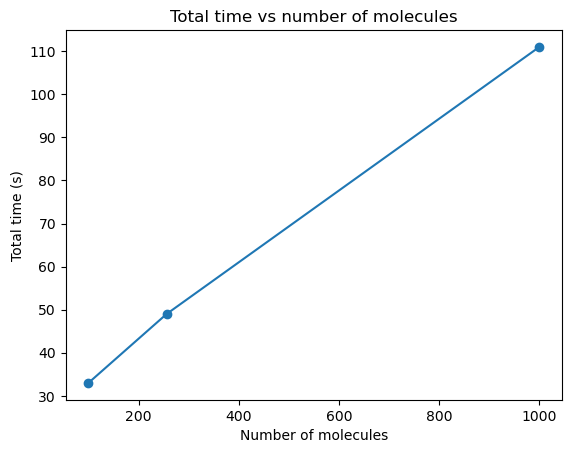

In [51]:
#plot: total time vs n
timings = [33,49,0+60+51]
ns = [100,256,1000]

import matplotlib.pyplot as plt
plt.plot(ns,timings, marker='o', linestyle='-')
plt.xlabel('Number of molecules')
plt.ylabel('Total time (s)')
plt.title('Total time vs number of molecules')

In [70]:
5000 * 500, 50 * 500

(2500000, 25000)